# Global Centroid Moment Tensor 3D (GCMT3D)

## The workflow

Make sure you are in the right virtual environment.


### Downloading the Data
The first step in the inversion process is downloading data that corresponds to the original solution of Global CMT Catalogue, which is maintained by the Lamont-Doherty Earth Observatory.

To do this we use the Specifically design DataRequest class. We have to define certain parameters before we download the data:

In [1]:
from gcmt3d.data import DataRequest

# Parameters
duration = 3600      # seconds, 1h = 3600s
channels = ['BHN','BHE','BHZ']   # needs to be a list
locations=['00']     # location 00 is the primary location for most seismometers
starttime_offset=-60 # -60 seconds is 1 min before the earthquakes inverted cmt solution 
resp_format="resp"   # response format


# Earthquake ID
eqID = "eq_060994A"
outputdir="data/"+eqID+"/"  # specific output directory here left open if left open files will 
                            # be saved in the folder wher the `.cmt` file is located


# Earthquake and Station parameters
cmt_filename = "data/" + eqID + "/earthquake_data/CMTSOLUTION"
stationlist_filename = "./src/gcmt3d/data/download/resources/stations.txt"

# Create Request Object   
Request = DataRequest.from_file(cmt_filename,
                                stationlist_filename,
                                duration=duration,
                                channels=channels,
                                locations=locations,
                                starttime_offset=starttime_offset,
                                outputdir=outputdir)

# Print Earthquake Download Info
print(Request)


Earthquake Parameters
--------------------------------------------------
Earthquake ID: 060994A
Origin Time: 1994-06-09T00:33:45.400000Z
Origin Latitude: -13.82
Origin Longitude: -67.25

Download Parameters:
--------------------------------------------------
Starttime: 1994-06-09T00:32:45.400000Z
Endtime: 1994-06-09T01:32:45.400000Z
Duration [s]: 3600
Channels: ['BHN', 'BHE', 'BHZ']
Locations: ['00']

Saving Parameters:
--------------------------------------------------
Output Directory: data/eq_060994A/



After setting up the Request and inspecting the parameters we can download the data:

In [2]:
# Download the data using the download method
Request.download()

Reading data selection from list file 'data/eq_060994A//request.txt'
Received 1.3 KB of metadata in 0.4 seconds (3.4 KB/s)
Processed metadata for 45 channel epochs in 0.4 seconds
Received 4.6 MB of time series data in 5.4 seconds (863.0 KB/s) - written to data/eq_060994A/seismograms/obs/060994A.mseed
Received 114.0 KB of StationXML in 0.6 seconds (182.1 KB/s)
DONE at 2019-04-07 18:50:52


The next step is to create a STATIONS file, which tells specfem3d_globe where to "record" the simulated traces:

In [148]:
# Creating STATIONS file
Request.specfem_list()


STATIONS FILE WRITTEN.



# Data to ASDF

Since the downloaded data can't simply be used in the `.mseed` format,
the data needs to be converted into a more versatile format. This can 
be done using obspy and pyasdf.

## Import observed data as streams

<IPython.core.display.Javascript object>


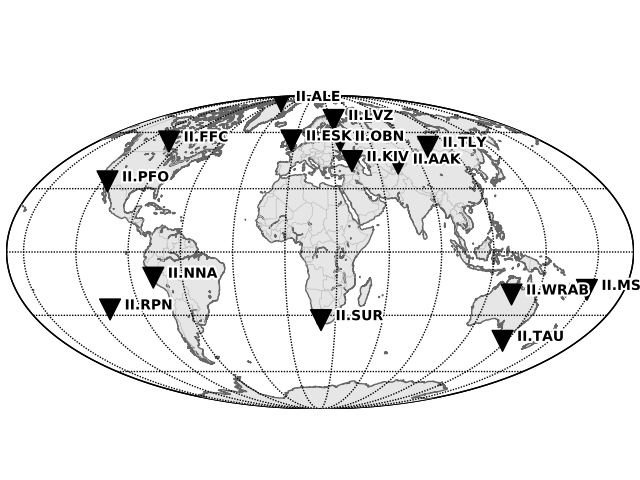

In [4]:
%matplotlib notebook
import numpy
from obspy import read, read_inventory
from gcmt3d import CMTSource
import matplotlib.pyplot as plt

# Import event
cmt_filename = "data/" + eqID + "/earthquake_data/CMTSOLUTION"
cmt = CMTSource.from_CMTSOLUTION_file(cmt_filename)
event_coordinates = (cmt.latitude,cmt.longitude)

# Read Station XML as inventory
obs_inv = read_inventory("data/" + eqID + "/station_data/station.xml")

# Plotting the station inventory
obs_inv.plot(color="black");

#Plotting the responses to check
# obs_inv[0:3].plot_response(1/150);


<IPython.core.display.Javascript object>


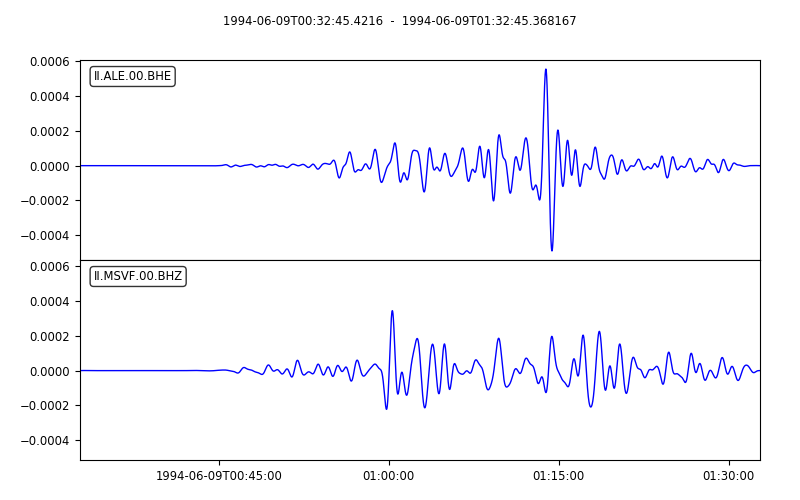

<IPython.core.display.Javascript object>


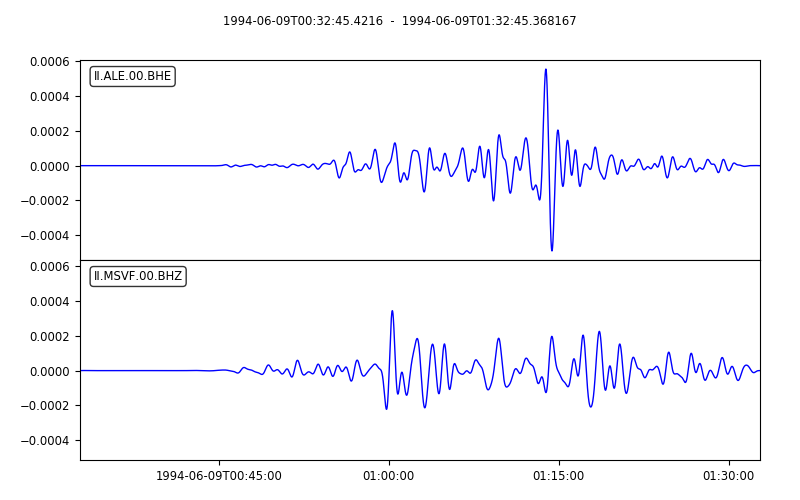

In [5]:
# Import traces
obs = read("data/"+eqID+"/seismograms/obs/"+eqID[3:]+".mseed");

# Cleanup duplicate traces or stitch uo traces with missing windows
obs.merge(fill_value=0)

# Detrending the traces
obs.detrend("linear")

# Tapering to reduce the ringing when filtering
obs.taper(max_percentage=0.05, type="hann")

# Remove the responses from the traces using the inventory
pre_filt = [0.001, 0.005, 45, 50]
obs.remove_response(inventory=obs_inv, pre_filt=pre_filt, output="DISP",water_level=60)

# Bandpass filter the traces using a butterworth filter
obs.filter("bandpass", freqmin=1/150, freqmax=1/40,zerophase=True)

# Plot the first n traces in the stream to check the results
n=3
obs[0:n-1].plot(color='blue')


Now, what we have is a source, an inventory with the station information 
and a stream object containing traces, from which the response has been 
removed and which have been normalized. To get an overview of the recorded
traces the next step is to plot them in a section as a function of distance 
to the earthquake. To do this we need to add either the epicentral distance 
to `stream.trace.stats.distance` or we can add the location to 
`stream.trace.stats.coordinates.latitude` and 
`stream.trace.stats.coordinates.longitude`. This is done by looping through 
the traces and finding the necessary info in the inventory file:


In [6]:
# Adding location to the traces
for st in obs:
    
    # Getting the seed_id to request the specific station location from inventory
    seed_id = st.get_id()
    
    # Get station coordinates from inventory
    temp = obs_inv.get_coordinates(seed_id)
    
    # Add coordinates to inventory
    st.stats.coordinates = {"latitude": temp["latitude"],
                            "longitude": temp["longitude"]}
 

After adding the coordinates to the traces, we can plot them:

In [7]:
print("Lat/Lon of first trace")
print(obs[0].stats.coordinates.latitude)
print(obs[0].stats.coordinates.longitude)
print("Lat/Lon of event")
print(event_coordinates[0])
print(event_coordinates[1])



Lat/Lon of first trace
-17.744801
178.052795
Lat/Lon of event
-13.82
-67.25


<IPython.core.display.Javascript object>


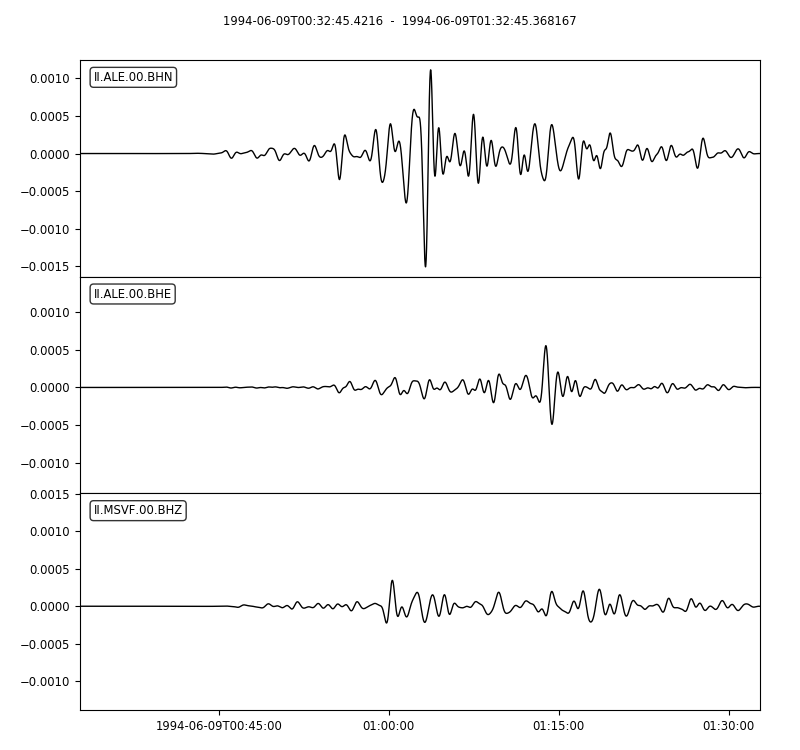

In [8]:
obs[0:3].plot()

# haha
x = 0;


<IPython.core.display.Javascript object>


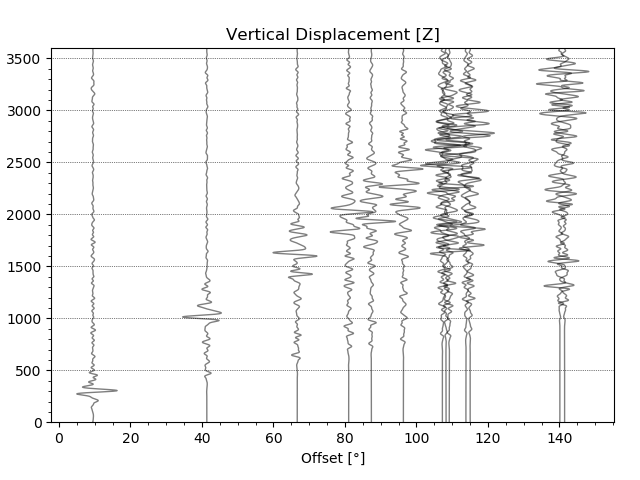

In [9]:
# Plotting the station as a function of their the displacement direction.
# Vertical:
figZ = plt.figure()
plt.title('Vertical Displacement [Z]')
obs[ ::3].plot(fig=figZ,ev_coord=event_coordinates,type='section',
               dist_degree=True,orientation="vertical");

<IPython.core.display.Javascript object>


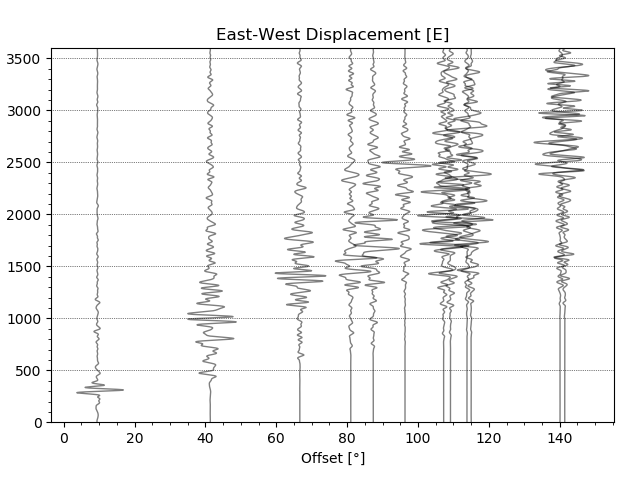

In [10]:
# East
figE = plt.figure()
plt.title('East-West Displacement [E]')
obs[1::3].plot(fig=figE,ev_coord=event_coordinates,type='section',
               dist_degree=True,orientation="vertical");

<IPython.core.display.Javascript object>


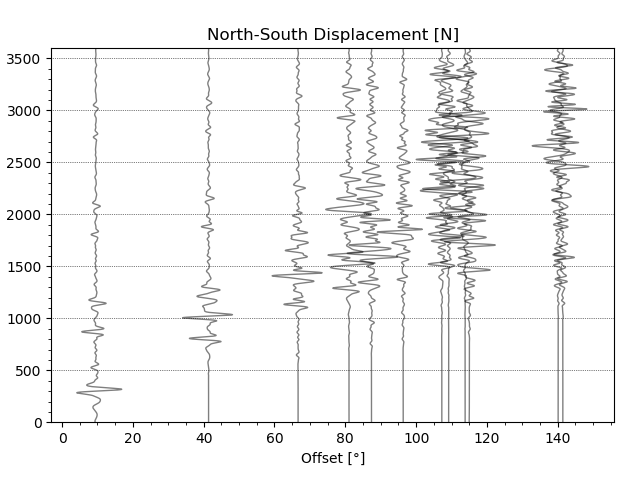

In [11]:
# North
figN = plt.figure()
plt.title('North-South Displacement [N]')
obs[2::3].plot(fig=figN,ev_coord=event_coordinates,type='section',
               dist_degree=True,orientation="vertical");

## Import Synthetics

Now we have our observed data for the earthquake and it's time to look at our synthetic data. We'll need the source again:

<IPython.core.display.Javascript object>


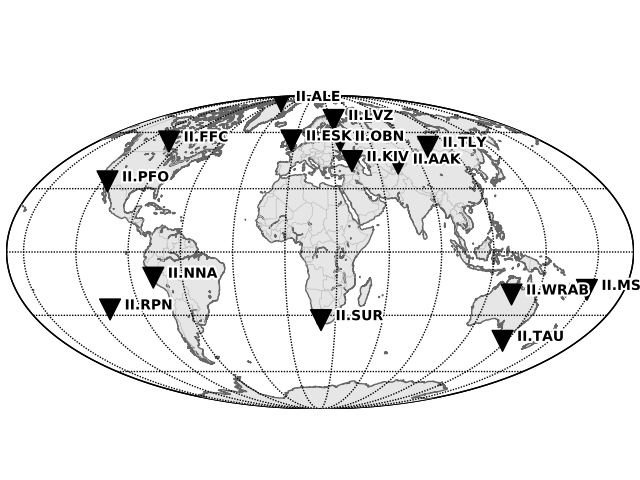

In [12]:
import numpy
from obspy import read, read_inventory
from gcmt3d import CMTSource
import matplotlib.pyplot as plt

# Import event
cmt_filename = "data/" + eqID + "/CMTSOLUTION"
cmt = CMTSource.from_CMTSOLUTION_file(cmt_filename)
event_coordinates = (cmt.latitude,cmt.longitude)

# Read Station XML as inventory
syn_inv = read_inventory("data/" + eqID + "/station.xml")

# Plotting the station inventory
syn_inv.plot(color="black");

And then, we we import the traces created by SPECFEM.

<IPython.core.display.Javascript object>


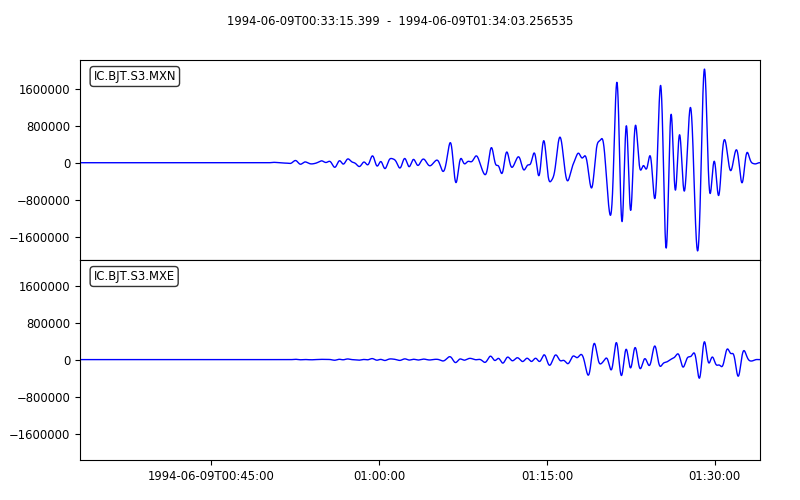

In [13]:
# Import traces
syn = read("data/"+eqID+"/seismograms/syn/*.sacan");

# Detrending the traces
syn.detrend("linear")

# Tapering to reduce the ringing when filtering
syn.taper(max_percentage=0.05, type="hann")

# Bandpass filter the traces using a butterworth filter
syn.filter("bandpass", freqmin=1/150, freqmax=1/40,zerophase=True)

# Plot the first n traces in the stream to check the results
n=3
syn[0:n-1].plot(color='blue')

# Random variable to make plot appear
randx=0;

Now, we need to assign coordinates to the the stream and the stations. To do that we first need to find which traces we have and which we don't. In other words, we have to create a subset of traces in the synthetics that are found in the observed stations.

In [14]:
import re # regexpression pattern matcher

# Adding location to the traces
for trace in syn:
    
    # Getting the seed_id to request the specific station location from inventory
    seed_id = trace.stats.network + "." + trace.stats.station + "." + trace.stats.location + "." + trace.stats.channel
    
    # Create Regex pattern
    pattern = trace.stats.network + "." + trace.stats.station + ".*" + trace.stats.channel[-1]
    
    if any(re.match(pattern, x.get_id()) for x in obs):
    
        # Get station coordinates from inventory
        temp = syn_inv.get_coordinates(seed_id = trace.stats.network + "." + trace.stats.station + "." + "00" + "." + "BH" + trace.stats.channel[-1])
    
        # Add coordinates to inventory
        trace.stats.coordinates = {"latitude": temp["latitude"],
                                "longitude": temp["longitude"]}
    else:
        syn.remove(trace)

In [15]:
print(syn.__str__(extended=True))     
print(obs.__str__(extended=True))

37 Trace(s) in Stream:
II.ALE.S3.MXE  | 1994-06-09T00:33:15.399000Z - 1994-06-09T01:34:03.256535Z | 7.0 Hz, 25600 samples
II.ALE.S3.MXN  | 1994-06-09T00:33:15.399000Z - 1994-06-09T01:34:03.256535Z | 7.0 Hz, 25600 samples
II.ALE.S3.MXZ  | 1994-06-09T00:33:15.399000Z - 1994-06-09T01:34:03.256535Z | 7.0 Hz, 25600 samples
II.ESK.S3.MXE  | 1994-06-09T00:33:15.399000Z - 1994-06-09T01:34:03.256535Z | 7.0 Hz, 25600 samples
II.ESK.S3.MXN  | 1994-06-09T00:33:15.399000Z - 1994-06-09T01:34:03.256535Z | 7.0 Hz, 25600 samples
II.ESK.S3.MXZ  | 1994-06-09T00:33:15.399000Z - 1994-06-09T01:34:03.256535Z | 7.0 Hz, 25600 samples
II.KIV.S3.MXE  | 1994-06-09T00:33:15.399000Z - 1994-06-09T01:34:03.256535Z | 7.0 Hz, 25600 samples
II.KIV.S3.MXN  | 1994-06-09T00:33:15.399000Z - 1994-06-09T01:34:03.256535Z | 7.0 Hz, 25600 samples
II.KIV.S3.MXZ  | 1994-06-09T00:33:15.399000Z - 1994-06-09T01:34:03.256535Z | 7.0 Hz, 25600 samples
II.LVZ.S3.MXE  | 1994-06-09T00:33:15.399000Z - 1994-06-09T01:34:03.256535Z | 7.0 Hz, 2

<IPython.core.display.Javascript object>


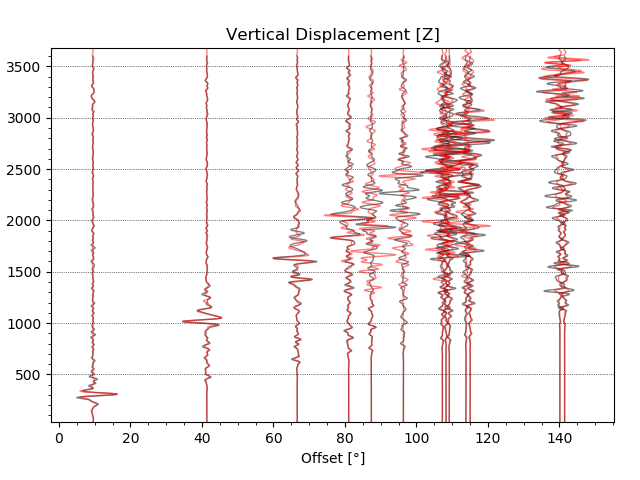

In [68]:
# Plotting the synthetic traces into the previous figure.
# Note the reference time shift!
figZ = plt.figure()
plt.title('Vertical Displacement [Z]')
obs[ ::3].plot(fig=figZ,ev_coord=event_coordinates,type='section',
               dist_degree=True,orientation="vertical",
              reftime=obs[0].stats.starttime);
syn[::3].plot(fig=figZ,ev_coord=event_coordinates,type='section',
              dist_degree=True,orientation="vertical",color='red',
              reftime=obs[0].stats.starttime-60+2.25);

<IPython.core.display.Javascript object>


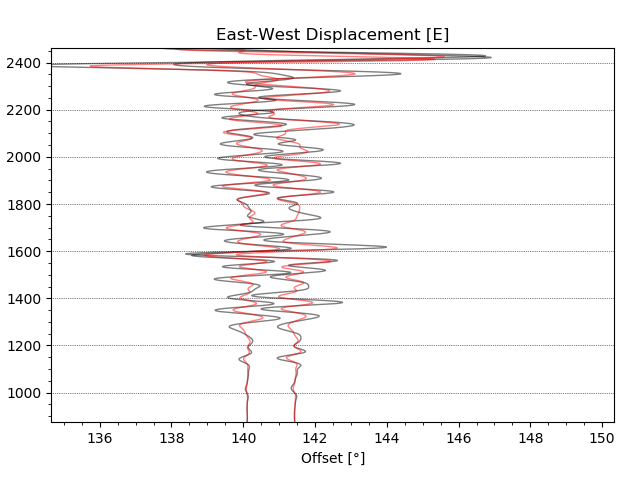

In [69]:
figE = plt.figure()
plt.title('East-West Displacement [E]')
obs[1::3].plot(fig=figE,ev_coord=event_coordinates,type='section',
               dist_degree=True,orientation="vertical",
              reftime=obs[0].stats.starttime);
syn[1::3].plot(fig=figE,ev_coord=event_coordinates,type='section',
               dist_degree=True,orientation="vertical",color='red',
              reftime=obs[0].stats.starttime-60+2.25);

<IPython.core.display.Javascript object>


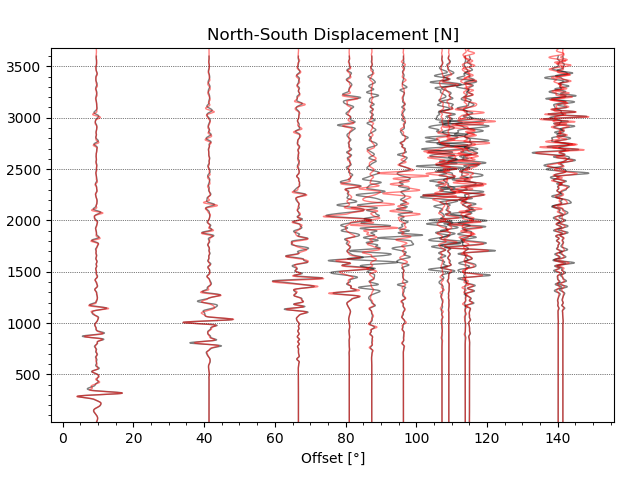

In [70]:
figN = plt.figure()
plt.title('North-South Displacement [N]')
obs[2::3].plot(fig=figN,ev_coord=event_coordinates,type='section',
               dist_degree=True,orientation="vertical",
              reftime=obs[0].stats.starttime);
syn[2::3].plot(fig=figN,ev_coord=event_coordinates,type='section',
               dist_degree=True,orientation="vertical",color='red',
              reftime=obs[0].stats.starttime-60+2.25);


For peace of mind, plot a single trace and see whether the synthetics really have different arrivals:

<IPython.core.display.Javascript object>


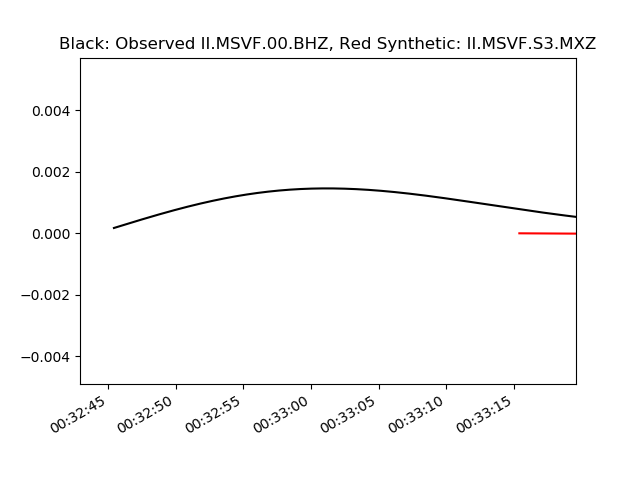

In [72]:
import numpy as np
from obspy.core.stream import Stream
from obspy.core.trace import Trace
obs_trace_id = obs[0].get_id()
type(obs_trace_id)
obs_trace    = obs.select(id=obs_trace_id)[0]

# Fixing synthetic trace
syn_trace = syn.select(id="II.MSVF.S3.MXZ")[0]

fig = plt.figure()
ax = plt.axes()
ax.plot(obs_trace.times("matplotlib"),
        obs_trace.data/np.max(np.abs(obs_trace.data)), "k-")
ax.plot(syn_trace.times("matplotlib"),
        syn_trace.data/np.max(np.abs(syn_trace.data)), "r-")
plt.title("Black: Observed %s, Red Synthetic: %s" % (obs_trace_id,syn_trace.get_id()))
# ax.legend("Observed","Synthetic")
ax.xaxis_date()
fig.autofmt_xdate()
plt.show()


## Create ASDF Data 

Now, we will create a collective data set of the synthetic and the observed data using pyASDF. The first step is simpyt to create the empty data set itself.

In [134]:
import pyasdf
ds = pyasdf.ASDFDataSet("data/"+eqID+"/"+eqID+".h5", compression="gzip-3")

Now that the data set is created, we have to populate it! However, as I just found out pyasdf just reads quakeMLs so I'll have to convert the earthquake to a quakeML 

In [135]:
import obspy

# Reset earthquake ID so stuff can be run from here.
eqID = "eq_060994A" 

# Load CMT solution into Catalogue
cat = obspy.read_events("data/" + eqID + "/earthquake_data/CMTSOLUTION")

# Write QuakeML to the same directory
cat.write("data/"+eqID+"/earthquake_data/"+eqID+".xml", format="quakeml")

Now that we have our quakeML, we can populate the ASDF file:

In [136]:
# Add QuakeML
quakeMLpath = "data/" + eqID + "/earthquake_data/"+ eqID + ".xml"
ds.add_quakeml(quakeMLpath)


With the first piece of information, we check whether it is really in the file:

In [138]:
print(ds)

ASDF file [format version: 1.0.2]: 'data/eq_060994A/eq_060994A.h5' (7.0 KB)
	Contains 1 event(s)
	Contains waveform data from 0 station(s).


Now, we add waveform data to the ASDF file

In [139]:
# Set earthquake accordingly
event=ds.events[0]

# Add observed waveform
observed_data_file = "data/" + eqID + "/seismograms/obs/"+ eqID[3:] + ".mseed"
ds.add_waveforms(observed_data_file, tag="raw_recording", event_id=event)

print(ds)

ASDF file [format version: 1.0.2]: 'data/eq_060994A/eq_060994A.h5' (4.4 MB)
	Contains 1 event(s)
	Contains waveform data from 13 station(s).


In [140]:
# Add station.xml
stationXMLpath = "data/"+eqID+"/station_data/station.xml"
ds.add_stationxml(stationXMLpath)

print(ds)

ASDF file [format version: 1.0.2]: 'data/eq_060994A/eq_060994A.h5' (4.7 MB)
	Contains 1 event(s)
	Contains waveform data from 15 station(s).


In [141]:
waveformList = ds.waveforms.list()
print(waveformList[0])

II.AAK


Before adding the synthetics we have to make sure that we delete unnecessary data. That is we only keep synthetic data that we also have a corresponding real station for.

In [142]:
from obspy import read
# First convert miniseed2sac using obspy
observed_dir = "data/" + eqID + "/seismograms/obs/"
observed_file = observed_data_dir + eqID[3:] + ".mseed"
observed = read(observed_file)

# write the observed data to sac files
for tr in observed: 
    tr.write(observed_data_dir + tr.id + ".sac", format="SAC")


Now, using glob we check the files in the observed directory against the synthetic directory and only add the necessary ones.

In [143]:
import os,glob,re

# Define location of the synthetics
synthetics_dir = "data/" + eqID + "/seismograms/syn/"
synthetics_files = synthetics_dir + "*.sacan"

# Define location of the observed data
observed_dir = "data/" + eqID + "/seismograms/obs/"
observed_files = observed_dir + "*.sac"

# Create list of all files in the directory
syn_list = glob.glob(synthetics_files)
obs_list = glob.glob(observed_files)

# Verbose?
verbose = 0

counter = 0

# Total number of synthetic files
N = len(syn_list)

# Iterate and delete
for _i, filename in enumerate(syn_list):
    # Increase counter
    counter +=1
    
    # Get name of file
    synfile = os.path.basename(filename).split(".")
    
    # Create pattern to check against
    pattern = observed_dir + synfile[0] + "." \
    + synfile[1] + ".*" + synfile[2][-1] + ".*"
    
    # Check against all filenames in observed list
    if any(re.match(pattern,x) for x in obs_list):
        if verbose:
            print('Keep trace %d of %d: %s' % (counter,N,".".join(synfile)))
    else:
        os.remove(filename)
        if verbose:
            print('Delete trace %d of %d: %s' % (counter,N,".".join(synfile)))
        
if verbose:
    print("\nSynthetics directory is all clean!\n")
    
    
    

In [144]:
# Add synthetics
synthetics_files = "data/" + eqID + "/seismograms/syn/*.sacan"

# verbose?
verbose = 1
files = glob.glob(synthetics_files)
for _i, filename in enumerate(files):
    if verbose:
        print("Adding file %i of %i ..." % (_i + 1, len(files)))
    ds.add_waveforms(filename, tag="synthetics", event_id=event)

print(ds)

Adding file 1 of 37 ...
Adding file 2 of 37 ...
Adding file 3 of 37 ...
Adding file 4 of 37 ...
Adding file 5 of 37 ...
Adding file 6 of 37 ...
Adding file 7 of 37 ...
Adding file 8 of 37 ...
Adding file 9 of 37 ...
Adding file 10 of 37 ...
Adding file 11 of 37 ...
Adding file 12 of 37 ...
Adding file 13 of 37 ...
Adding file 14 of 37 ...
Adding file 15 of 37 ...
Adding file 16 of 37 ...
Adding file 17 of 37 ...
Adding file 18 of 37 ...
Adding file 19 of 37 ...
Adding file 20 of 37 ...
Adding file 21 of 37 ...
Adding file 22 of 37 ...
Adding file 23 of 37 ...
Adding file 24 of 37 ...
Adding file 25 of 37 ...
Adding file 26 of 37 ...
Adding file 27 of 37 ...
Adding file 28 of 37 ...
Adding file 29 of 37 ...
Adding file 30 of 37 ...
Adding file 31 of 37 ...
Adding file 32 of 37 ...
Adding file 33 of 37 ...
Adding file 34 of 37 ...
Adding file 35 of 37 ...
Adding file 36 of 37 ...
Adding file 37 of 37 ...
ASDF file [format version: 1.0.2]: 'data/eq_060994A/eq_060994A.h5' (7.2 MB)
	Contain

In [145]:
print(ds.waveforms["II.ALE"])

Contents of the data set for station II.ALE:
    - Has a StationXML file
    - 2 Waveform Tag(s):
        raw_recording
        synthetics


Now stuff is in ASDF format and we can get the windows using pyflex.

## PyFLEX

Pyflex is an algorithm that finds appropriate windows to compare to traces.

